In [233]:
#### ADJUST THE INPUTS BELOW AND RUN ALL CELLS TO COMPARE THE LCOE OF FUSION POWER CONVERSION STRATEGIES ##### 

inputs = {
    "power": 500, #MW, output power
    "specific_CAPEX_baseline": 6000, # USD/kW, assumes a fusion reactor with conventional thermal-to-electric power conversion as the baseline
    "powercost": 0.10, # USD/kWh, regional power cost
    "discount_rate": 0.08, # %/100
    "project_lifespan": 40, # years
    "construction_time": [5, 4], # years, construction time for [Thermal-to-Electric, Direct EM Capture] power conversion types
    "Qeng": [10, 5], #Q values for [Thermal-to-Electric, Direct EM Capture] power conversion types
    "capacity_factor": [0.85, 0.75], #utilization percentage for [Thermal-to-Electric, Direct EM Capture] power conversion types 
    "regulatory_factor": -10  # percent change to fusion plant CAPEX as a result of DEC-specific regulations

}

In [234]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
import pandas as pd
from tabulate import tabulate  # Install with: pip install tabulate (if not available)


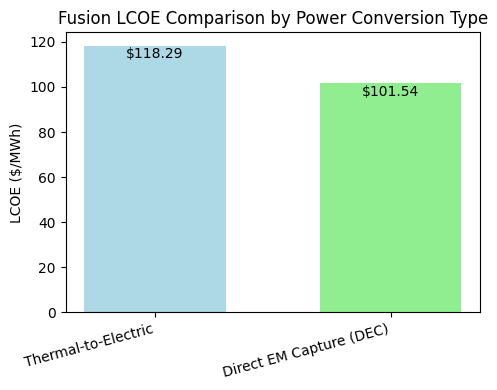

+---------------------------------------------------+-----------------------+---------------------+
| Metric                                            | Thermal-to-Electric   | Direct EM Capture   |
+===================================================+=======================+=====================+
| CAPEX (M$)                                        | 3000                  | 2370                |
+---------------------------------------------------+-----------------------+---------------------+
| O&M (discounted over lifetime, M$)                | 574                   | 553                 |
+---------------------------------------------------+-----------------------+---------------------+
| Energy Generation (discounted over lifetime, MWh) | 30,214,719.0          | 28,792,850.0        |
+---------------------------------------------------+-----------------------+---------------------+
| LCOE ($/kWh)                                      | 0.118                 | 0.102               |


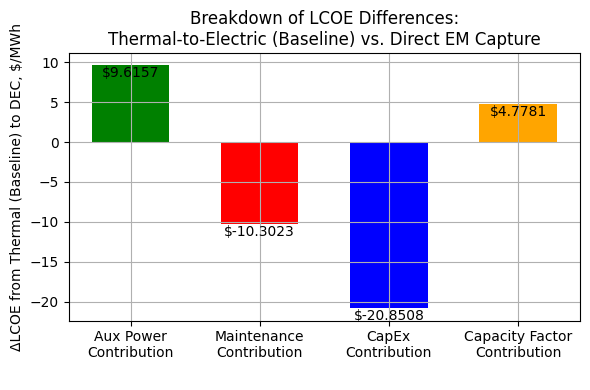

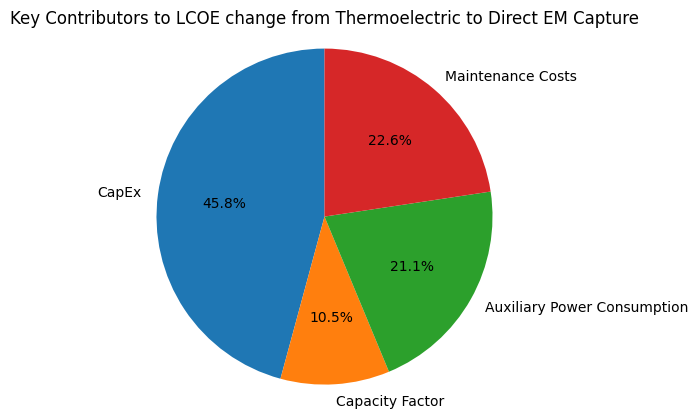

In [235]:

def run(inputs: dict) -> dict:
    # Extract inputs
    P = inputs["power"]  # Output Power
    powercost = inputs["powercost"] # Regional Power Cost
    r = inputs["discount_rate"]  # Discount Rate
    N = inputs["project_lifespan"]  # Lifespan
    reg_change = inputs["regulatory_factor"] # % change to baseline CAPEX as a result of DEC-specific regulations. DEC is assumed to be lower because of lower radioactive waste
    Q = inputs["Qeng"] #Qeng, based on EU DEMO and Helion Data
    specificinvcost = inputs["specific_CAPEX_baseline"] # USD/kW, average CAPEX estimate for "conventional" reactor w/ Thermal-to-Electric Power Conversion
    Tc = inputs["construction_time"] # construction time, years.  DEC assumed to be shorter because of smaller footprint and BOM 
    CF = inputs["capacity_factor"] #Capacity factor for a Reactor w/ [Thermal-to-Electric, Direct Energy Capture]. DEC is assumed to be less because of fast pulsing requirements
    
    hrsperyear = 8760
    Pin = [P/Q[0], P/Q[1]] #MW, input power, Thermal-to-Electric

    ##### Energy Generation Calcs #########
    T_Deg = [0.0, 0.0]  #temporal degradation of generation output per year
    
    disc_E_TtoE = P * hrsperyear * CF[0] * np.sum((1 - T_Deg[0])**(n-1) / ((1 + r)**(n + Tc[0])) for n in range(1, N+1)) #discounted energy generation over lifespan, inc. degradataion
    disc_E_DEC = P * hrsperyear * CF[1] * np.sum((1 - T_Deg[1])**(n-1) / ((1 + r)**(n + Tc[1])) for n in range(1, N+1)) #discounted energy generation over lifespan, inc. degradataion
    
    ###### Maintenance & Replacement Calcs ###### << Focusing on the delta between Thermal and DEC maintenance costs
    
    replacement_interval = 3  # Years between major maintenance, ROM estimate
    num_replacements = math.floor(N/replacement_interval)
    replacement_cost = 250*1e3* P #USD, estimated from https://arxiv.org/pdf/2405.01514
    # Calculate replacement intervals
    nrepl = [int(i * replacement_interval) for i in range(1, int(N / replacement_interval) + 1) if int(i * replacement_interval) <= N]
    # Ensure replacements don't exceed lifespan
    nrepl = [year for year in nrepl if year < N]
    discreplacement_costs = sum(replacement_cost/ (1 + r)**(n + Tc[0]) for n in nrepl) #replacement costs only count blanket costs and thus only apply to Thermal-to-Electric configs.

    ##### CAPEX Calcs #######

    CAPEX_TtoE = specificinvcost * P * 1e3 #USD, ROM estimate
    footprint_delta = -50 #USD/kW DEC will be smaller due to higher power conversion efficiency and lack of turbine hall
    turbine_delta = -400 #USD/kW, approx. cost of steam turbine system that gets eliminated with DEC
    BoP_delta = -200  #USD/kW, approx. cost of cooling towers, heat exchangers, etc. that get elimintated with DEC
    molten_salt_delta = -100  #USD/kW, approx. cost of molten salt tanks that get eliminated with DEC
    blanket_delta = -60  #USD/kW,  approx. cost of blanket architecture that gets eliminated with DEC
    pwr_electr_delta = 150 #USD/kW, approx. cost of additional power electronics and controls required for high-frequency DEC
    
    TotalCAPEXDelta = P*1e3*(pwr_electr_delta + turbine_delta + BoP_delta + molten_salt_delta + blanket_delta + footprint_delta) #DEC CAPEX is assumed to be less, given the simpler power conversion architecture
    CAPEX_DEC = (CAPEX_TtoE * (1+ reg_change/100)) + TotalCAPEXDelta  #USD

    ##### OPEX Calcs #######

    OPEX_TtoE =  0.01 * CAPEX_TtoE # assumes that yearly OPEX is ~1% of CAPEX (not including maintenance, calculated above)
    OPEX_Delta= (Pin[1] * 1e3 * hrsperyear* CF[1] * powercost) - (Pin[0] * 1e3 * hrsperyear* CF[0] * powercost) # Fuel cost delta is ignored since He3 would theoretically be bred within reactor
    OPEX_DEC = OPEX_TtoE + OPEX_Delta 

    discOPEX_TtoE = sum(OPEX_TtoE/ (1 + r)**(n+Tc[0]) for n in range(N)) #USD, discounted OPEX over lifespan
    discOPEX_DEC = sum(OPEX_DEC/ (1 + r)**(n+Tc[1]) for n in range(N))  #USD, discounted OPEX over lifespan
    
    ##### LCOE Calcs #######

    LCOE_TtoE = (CAPEX_TtoE + discreplacement_costs + discOPEX_TtoE) / (disc_E_TtoE * 1000)  #$/kWh
    LCOE_DEC = (CAPEX_DEC + discOPEX_DEC) / (disc_E_DEC * 1000)   #$/kWh

    ######### CHARTS ########
    
    categories = ['Thermal-to-Electric', 'Direct EM Capture (DEC)']
    lcoe_values = [LCOE_TtoE * 1000, LCOE_DEC * 1000]  # Scale to $/MWh for chart labels
    
    x_pos = np.arange(len(categories))
    width = 0.6
    
    fig, ax = plt.subplots(figsize=(5, 4))
    bars = ax.bar(x_pos, lcoe_values, width, align='center', color=['lightblue', 'lightgreen'])
    
    # Add labels and title
    ax.set_ylabel('LCOE ($/MWh)')
    plt.title('Fusion LCOE Comparison by Power Conversion Type')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, rotation=15, ha='right')
    
    # Add value labels below bars
    for bar, val in zip(bars, lcoe_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height - 0.5,  # Below the bar
                f'${val:.2f}', ha='center', va='top')  # va='top' anchors text top to y-position
    
    # Tight layout and show
    plt.tight_layout()
    plt.show()

    
    
    data = {
    'Metric': [
        'CAPEX (M$)',
        'O&M (discounted over lifetime, M$)',
        'Energy Generation (discounted over lifetime, MWh)',
        'LCOE ($/kWh)'
    ],
    'Thermal-to-Electric': [
        f"{CAPEX_TtoE/1e6:0.0f}",
        f"{(discOPEX_TtoE+discreplacement_costs)/1e6:0.0f}",
        f"{np.round(disc_E_TtoE):,}",
        f"{LCOE_TtoE:0.3f}"
    ],
    'Direct EM Capture': [
        f"{CAPEX_DEC/1e6:0.0f}",
        f"{discOPEX_DEC/1e6:0.0f}",  # Note: Your original had no 'M' for DEC O&M—adjust if needed
        f"{np.round(disc_E_DEC):,}",
        f"{LCOE_DEC:0.3f}"
    ]
    }
    
    df = pd.DataFrame(data)
    
    # Print with borders/outlines using tabulate (grid format for full table borders)
    print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))

    
    # Create the bar chart
    opexcontr = (discOPEX_DEC-discOPEX_TtoE)/(disc_E_TtoE) # change to LCOE in $/MWh from OPEX delta (lifetime discounted)
    replcontr = (-1*discreplacement_costs)/(disc_E_TtoE) # change to LCOE in $/MWh from maintenance cost delta (lifetime discounted)
    capexcontr = (CAPEX_TtoE*(reg_change/100) + TotalCAPEXDelta )/(disc_E_TtoE) # change to LCOE in $/MWh from CAPEX delta 
    gencontr = (LCOE_DEC - LCOE_TtoE)*1000-( opexcontr + replcontr + capexcontr) #change to LCOE in $/MWh from generation throughput delta
    categories = ['Aux Power\nContribution', 'Maintenance\nContribution', 'CapEx\nContribution', 'Capacity Factor\nContribution']
    values = [opexcontr, replcontr, capexcontr, gencontr]  # $/kWh; multiply by 1000 for $/MWh if needed
    
    x_pos = np.arange(len(categories))
    width = 0.6
    
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(x_pos, values, width, align='center', color=['green', 'red', 'blue', 'orange'])  
    
    # Add labels and title
    ax.set_xlabel(' ')
    ax.set_ylabel('ΔLCOE from Thermal (Baseline) to DEC, $/MWh')
    ax.set_title('Breakdown of LCOE Differences:\nThermal-to-Electric (Baseline) vs. Direct EM Capture')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, rotation=0, ha='center')
    
    # Add value labels below bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height - max(values)*0.01,  # Slight offset below
                f'${val:.4f}', ha='center', va='top', fontsize=10)
    
    # Tight layout and show
    plt.tight_layout()
    plt.grid()
    plt.show()

    
    # Create the pie chart
    sumchange =  abs(opexcontr) + abs(replcontr) + abs(capexcontr) + abs(gencontr)

    percentopex = abs(opexcontr)/ sumchange * 100
    percentrepl = abs(replcontr)/sumchange * 100
    percentcapex = abs(capexcontr)/ sumchange * 100
    percentgen = abs(gencontr)/ sumchange * 100
    
    sizes = [percentcapex, percentgen, percentopex, percentrepl]
    labels = ['CapEx', 'Capacity Factor', 'Auxiliary Power Consumption', 'Maintenance Costs']
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    
    # Equal aspect ratio ensures pie is circular
    ax.axis('equal')
    
    # Add a title
    plt.title('Key Contributors to LCOE change from Thermoelectric to Direct EM Capture')
    
    # Display the chart
    plt.show()


    return {
        "LCOE_thermal": LCOE_TtoE,
        "LCOE_DEC": LCOE_DEC,
        "CAPEX_thermal": CAPEX_TtoE/1e6, #Million USD
        "CAPEX_DEC": CAPEX_DEC/1e6, #Million USD
        "OPEX_thermal": (discOPEX_TtoE+ discreplacement_costs)/1e6, #Million USD
        "OPEX_DEC": discOPEX_DEC/1e6, # #Million USD
        "discountedE_TtoE": disc_E_TtoE, #MWh
        "discountedE_DEC": disc_E_DEC #MWh

    }
    
results = run(inputs)
